In [130]:
#importing necessary libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import emoji
from nltk.corpus import stopwords
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
sw=stopwords

In [131]:
import tensorflow as tf

In [132]:
#loading the file into a data variable
Data=pd.read_excel('Group3-news-text-sanitized (1).xlsx') 

Performing EDA

In [133]:
Data['Category'].value_counts()

Not Relevant    5931
Relevant        4376
Can't Decide      16
Name: Category, dtype: int64

<Axes: xlabel='Category', ylabel='count'>

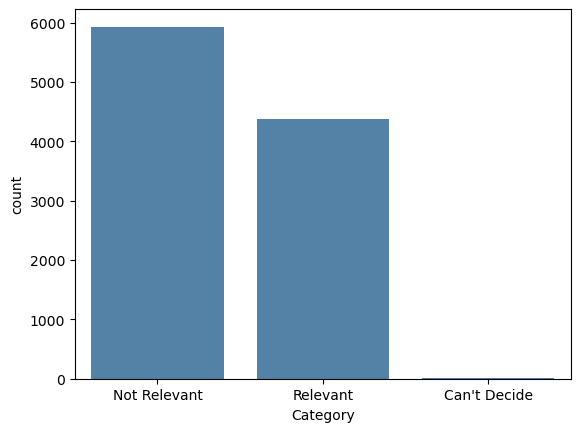

In [134]:
sns.countplot(x='Category',data=Data,color='steelblue')

In [135]:
#length of data before dropping the duplicates
len(Data)

10323

In [136]:
Data = Data.drop_duplicates('Tweet',keep='first') #drop duplicates

In [137]:
#Total amount of data after dropping the duplicates
len(Data)

10138

In [138]:
#using regular expressions to clean the tweet column
Data["Cleaned_Tweet"] = [re.sub(r"(@[A-Za-z0–9_]+)|[^\w\s]|#|http\S+", "", v.lower()) for v in Data["Tweet"]]

In [139]:
#preprocessing the text data after cleaning with regular expression - steps involved are stop words removal, demojize, removing spaces. 
def normalizepreprocessdata(data):
    stop_words = set(stopwords.words('english'))
    # Removing the stop wors form the data.
    words = [word for word in data.split() if word not in stop_words]
    # Normalize emojis
    words = [emoji.demojize(tweet) for tweet in words]
    # Remove unnecessary spacing and handle repeated characters
    words = [re.sub(r'(.)\1+', r'\1\1', word.strip()) for word in words]
    words = ' '.join(words)
    return words

In [140]:
Data["Cleaned_Tweet"] = Data["Cleaned_Tweet"].apply(normalizepreprocessdata) #cleaned tweets

In [141]:
#now that we have a column named clened tweets we are dropping the initial tweet column
Data.drop('Tweet',axis=1)

,Category,Confidence,Cleaned_Tweet
0,Not Relevant,1.0000,hey
1,Not Relevant,1.0000,whats man
2,Not Relevant,1.0000,love fruits
3,Not Relevant,1.0000,summer lovely
4,Not Relevant,1.0000,car fast
...,...,...,...
10318,Relevant,0.3994,make man pikin crash
10319,Relevant,0.3994,disregard snap story angry white girl riot hap...
10320,Relevant,0.3982,tornado singapore mac cheese around world mac ...
10321,Not Relevant,0.3367,check data upper wabash reservoirs site


In [142]:
#since we dont have enough data for can't decide category, we are dropping the rows with can;t decide
Data=Data[Data['Category']!= "Can't Decide"]

In [143]:
len(Data)

10124

In [144]:
#Replacing Relevant category with 1 and not relevant with 0
Data['Category']=Data['Category'].replace({"Relevant":1,"Not Relevant":0})

In [145]:
len(Data)

10124

In [146]:
Data['Category'].unique()

array([0, 1], dtype=int64)

In [147]:
np.random.seed(42)
tf.random.set_seed(42)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(Data['Cleaned_Tweet'], Data['Category'], test_size=0.2, random_state=42) # Split the data into training and testing sets

In [149]:
#tokenizing the data
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [150]:
#padding the training and testing sequences
max_sequence_length = 100  
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length) 
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

Creating an LSTM model

In [151]:
from keras.layers import Dense, Activation, Flatten,Dropout

In [152]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 50, input_length=max_sequence_length))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
#when we build a more complex neural network our model was overfitting, so we chose two layers of 32 each
model.add(Dense(1, activation='sigmoid'))

We have tried multiple optimizers and different layers with the model. By grid search CV and Bayesian optimization we found that rmsprop yields the best results. We have tested all the code in the test branch of our github

In [153]:
#compiling and training the model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history=model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=6, batch_size=32)

Epoch 1/6
254/254 [==============================] - 24s 74ms/step - loss: 0.5399 - accuracy: 0.7237 - val_loss: 0.4508 - val_accuracy: 0.7896
Epoch 2/6
254/254 [==============================] - 17s 68ms/step - loss: 0.3717 - accuracy: 0.8428 - val_loss: 0.4498 - val_accuracy: 0.8074
Epoch 3/6
254/254 [==============================] - 17s 67ms/step - loss: 0.3229 - accuracy: 0.8655 - val_loss: 0.4693 - val_accuracy: 0.8025
Epoch 4/6
254/254 [==============================] - 18s 71ms/step - loss: 0.2923 - accuracy: 0.8811 - val_loss: 0.4470 - val_accuracy: 0.8079
Epoch 5/6
254/254 [==============================] - 18s 70ms/step - loss: 0.2678 - accuracy: 0.8934 - val_loss: 0.4850 - val_accuracy: 0.8099
Epoch 6/6
254/254 [==============================] - 18s 71ms/step - loss: 0.2487 - accuracy: 0.9049 - val_loss: 0.4901 - val_accuracy: 0.8020


In [171]:
#Plotting training and validation accuracy
accuracy=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(accuracy))

Text(0.5, 1.0, 'Training and validation accuracy')

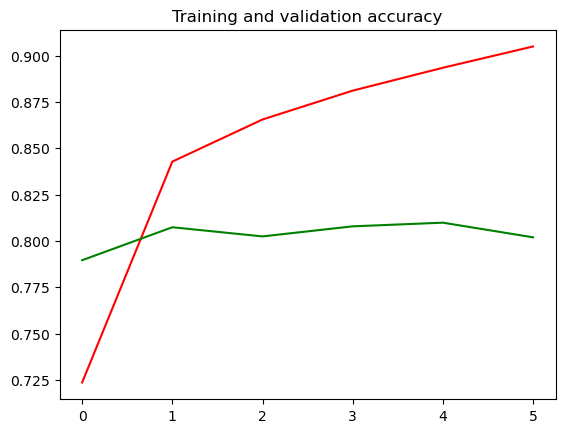

In [172]:
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')

In [173]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [174]:
#calculating accuracy score
y_pred = model.predict(X_test_padded) 
auc = roc_auc_score(y_test, y_pred)  
print("AUC:", auc)

64/64 [==============================] - 2s 24ms/step
AUC: 0.8649844303553966


In [175]:
LSTM_model_pred = tf.squeeze(tf.round(y_pred)) #LSTM model

In [176]:
LSTM_Model_acc=accuracy_score(y_test,LSTM_model_pred) 

In [177]:
#model accuracy
LSTM_Model_acc

0.8019753086419753

In [178]:
y_pred_binary = (y_pred > 0.5).astype(int)

Confusion Matrix:
[[974 203]
 [198 650]]


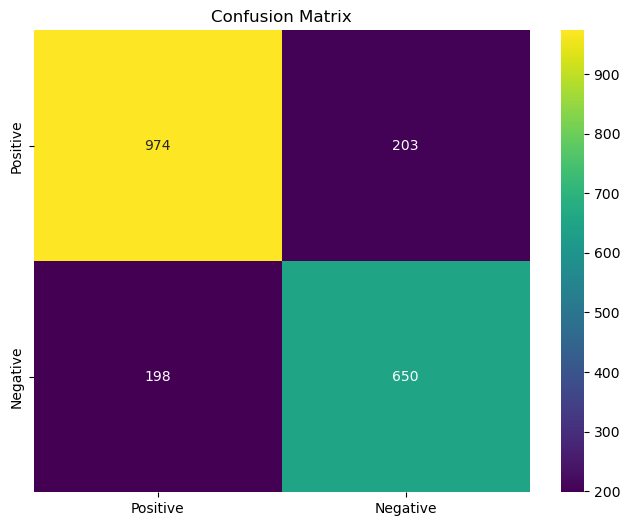

In [179]:
#plotting the confusion matrix
confusionmetrices = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(confusionmetrices)

clabel = ["Positive","Negative"]
plt.figure(figsize=(8,6))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
sns.heatmap(confusionmetrices, annot=True, fmt="d", cmap="viridis",xticklabels=clabel, yticklabels=clabel)
plt.show()

In [180]:
#Printing all the ,misclassified tweets
misclassified_indices = [indx for indx, (truelabel, predlabel) in enumerate(zip(y_test, y_pred_binary)) if truelabel != predlabel]
print("Total Misclassified tweets - " + str(len(misclassified_indices)) + "\n")

for idx in misclassified_indices:
    truelabel = y_test.iloc[idx]
    predlabel = y_pred_binary[idx][0]
    tweet = X_test.iloc[idx]
    print(f"Actual: " + str(truelabel) + " Predicted: " + str(predlabel) + " Tweet: " + tweet)

Total Misclassified tweets - 401

Actual: 1 Predicted: 0 Tweet: send flying cliff straight smoke spliff
Actual: 0 Predicted: 1 Tweet: moi cest plutot disconnected reason close strangers heartbreak girl rejects social casualty ufhguhfidt
Actual: 0 Predicted: 1 Tweet: survived plague floated flood peeked heads mud ones immune deafening bells god survive
Actual: 1 Predicted: 0 Tweet: sabrina dad rescued dude kept cage weve since 4
Actual: 1 Predicted: 0 Tweet: sinkhole selfies wont believe whats brooklyn sinkhole sinkhole selfies wont belie
Actual: 1 Predicted: 0 Tweet: 6 see pic clearly inundated good try though
Actual: 1 Predicted: 0 Tweet: armageddon
Actual: 1 Predicted: 0 Tweet: great michigan technique camp b1g thanks 1019 8r13 goblue wrestleon
Actual: 1 Predicted: 0 Tweet: would paramedic really leave someone inside building thats collapseblow
Actual: 1 Predicted: 0 Tweet: nowplaying dubstep hardstyle trap messy mix event recording alien casualty
Actual: 0 Predicted: 1 Tweet: 24 als

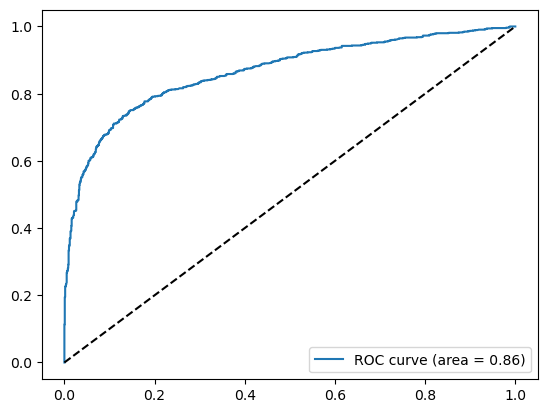

In [181]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred) # Compute the ROC curve by comparing the predicted probabilities (y_pred) to the true labels (y_test).
plt.figure() # Create a new figure to plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc) # Plot the ROC curve using the false positive rate (fpr) on the x-axis and the true positive rate (tpr) on the y-axis.
plt.plot([0, 1], [0, 1], 'k--') # Plot the diagonal line representing the ROC curve for a random classifier.
plt.legend(loc="lower right") # Add a legend to the plot, placing it in the lower right corner.
plt.show() #displaying the graph

In [182]:
model.save('F1_model.h5')

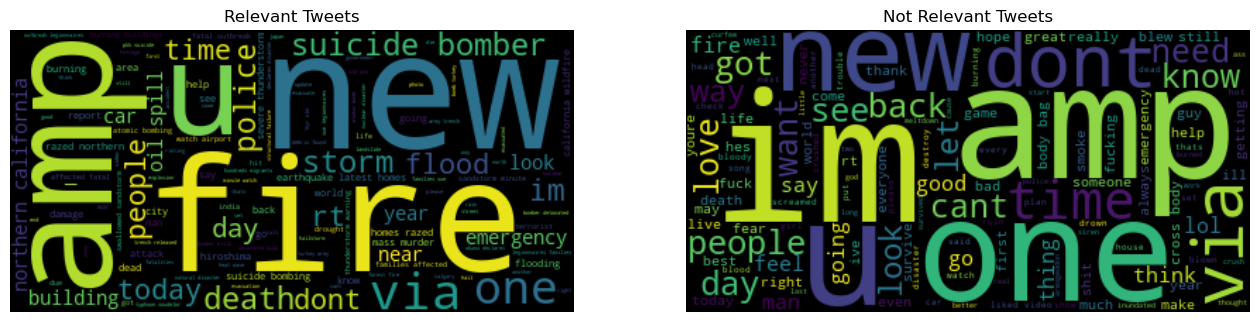

In [166]:
#plotting the word cloud
relevant_tweets = Data.query("Category==1")["Cleaned_Tweet"].apply(str).str.cat(sep=' ')
not_relevant_tweets = Data.query("Category==0")["Cleaned_Tweet"].apply(str).str.cat(sep=' ')
relevant_wordcloud = WordCloud().generate(relevant_tweets)
not_relevant_wordcloud = WordCloud().generate(not_relevant_tweets)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(relevant_wordcloud, interpolation="bilinear")
plt.title("Relevant Tweets")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(not_relevant_wordcloud, interpolation="bilinear")
plt.title("Not Relevant Tweets")
plt.axis("off")
plt.show()
